# Pyro Reprojection Tests

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyvista as pv
from matplotlib.pyplot import cm
from tqdm import tqdm
import torch

from collab_env.alignment import reprojection
from collab_env.data.file_utils import get_project_root
from collab_env.utils import visualization as viz

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Get info from GCloud

In [3]:
data_type = "fieldwork_processed"
session = "2024_02_06-session_0001"
splat_video = "C0043"
camera_id = "rgb_1"

# Make the session directory
session_data_dir = get_project_root() / "data" / data_type / session

# Requirements for alignment
environment_dir = session_data_dir / "environment"
aligned_frames_dir = session_data_dir / "aligned_frames" / camera_id
aligned_splat_dir = session_data_dir / "aligned_splat" / camera_id

# Files for reprojection
mesh_fn = environment_dir / splat_video / "rade-features" / "mesh" / "mesh.ply"
aligned_camera_fn = aligned_splat_dir / f"{camera_id}_mesh-aligned.pkl"
tracking_fn = aligned_frames_dir / f"{camera_id}_tracked_bboxes.csv"

Load the required files

In [4]:
# Tracks over the 2d video
df_tracks = pd.read_csv(tracking_fn)
df_tracks["track_id"] = df_tracks["track_id"].astype(int)

# Camera aligned to the mesh
with open(aligned_camera_fn, "rb") as f:
    camera_params = pickle.load(f)

### Create reprojection objects

In [5]:
# Create the camera to reproject from
camera = reprojection.Camera(
    K=camera_params["K"],
    c2w=camera_params["c2w"],
    width=camera_params["width"],
    height=camera_params["height"],
)

# Create the mesh to reproject to
mesh_environment = reprojection.MeshEnvironment(mesh_fn)

# Render the camera view of the mesh --> updates camera.image and camera.depth
image, depth = mesh_environment.render_camera(camera)

[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x7f7224a4d010 (threading is enabled)
EGL(1.5)
OpenGL(4.1)


Visualize camera view of the mesh

(-0.5, 639.5, 479.5, -0.5)

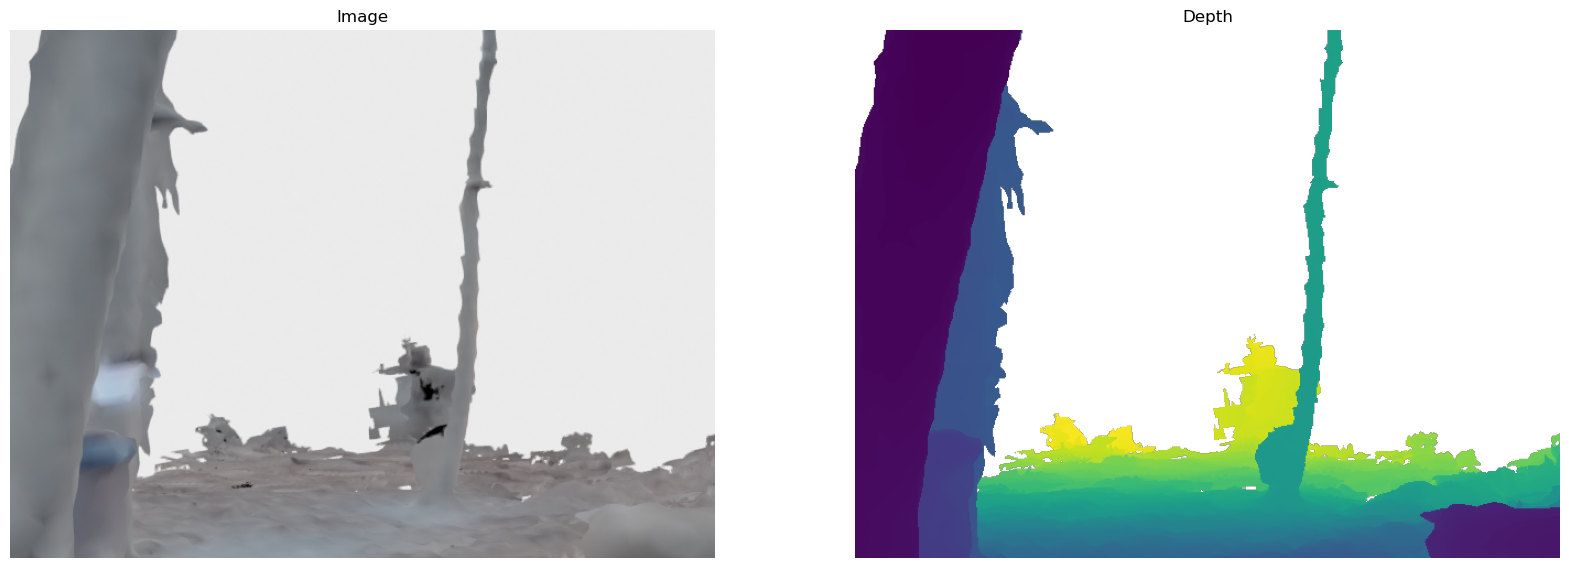

In [6]:
# Plot the image and depth
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].imshow(image)
axs[0].set_title("Image")
axs[0].axis("off")

axs[1].imshow(depth)
axs[1].set_title("Depth")
axs[1].axis("off")

### Map track bboxes to worldspace 

In [7]:
import numpy as np
import pandas as pd
from tqdm import tqdm

def project_tracks(df_tracks, camera, n_min_frames=25, std_threshold=2):
    """
    Clean and process tracking data.

    Steps:
        1. Filter out tracks with fewer than `n_min_frames`.
        2. Convert bounding boxes to image coordinates (u, v).
        3. Filter, smooth, and project valid coordinates to world space.
    
    Args:
        df_tracks (pd.DataFrame): DataFrame containing tracking data with columns ['track_id', 'x1', 'y1', 'x2', 'y2'].
        camera: Camera object with methods `project_to_world` and `depth` attribute.
        n_min_frames (int): Minimum number of frames required to keep a track.
        std_threshold (float): Standard deviation threshold for filtering coordinates.
    
    Returns:
        pd.DataFrame: Processed tracks with valid (u, v) and (x, y, z) coordinates.
    """
    
    # -------------------------------
    # 1. Filter tracks by minimum frames
    # -------------------------------
    track_counts = df_tracks.groupby("track_id").size()
    valid_track_ids = track_counts[track_counts >= n_min_frames].index
    df_valid_tracks = df_tracks[df_tracks["track_id"].isin(valid_track_ids)].copy()

    # -------------------------------
    # 2. Convert bounding boxes to image coordinates
    # -------------------------------
    bbox_coords = df_valid_tracks[["x1", "y1", "x2", "y2"]].values.astype(float)
    uv_coords = reprojection.bbox_to_coords(bbox_coords)
    df_valid_tracks[["u", "v"]] = uv_coords

    # Calculate the size of the bounding box
    df_valid_tracks["size"] = (df_valid_tracks["x2"] - df_valid_tracks["x1"]) * (df_valid_tracks["y2"] - df_valid_tracks["y1"])

    # -------------------------------
    # 3. Filter, smooth, and project to world coordinates
    # -------------------------------
    projected_tracks = []

    for _, df_track in tqdm(df_valid_tracks.groupby("track_id"), desc="Processing tracks"):

        uv = df_track[["u", "v"]].values.astype(int)

        # Find nan values based on depth --> this performs our constraint
        nan_mask = torch.isinf(camera.depth[uv[:, 1], uv[:, 0]])
        uv_masked = uv[~nan_mask]

        if uv_masked.shape[0] == 0 or uv_masked.shape[0] < n_min_frames:
            continue

        # Filter and smooth the coordinates within image space (u, v)
        filtered_coords = reprojection.filter_coords(uv_masked, std_threshold=2)
        smoothed_coords = reprojection.smooth_coords(filtered_coords)

        # Project to world space
        smoothed_coords = torch.as_tensor(smoothed_coords)
        xyz = camera.project_to_world(smoothed_coords)

        # Add to the dataframe (based on valid values)
        np_mask = np.asarray(nan_mask)
        df_track.loc[~np_mask, ["u", "v"]] = uv_masked
        df_track.loc[~np_mask, ["x", "y", "z"]] = np.asarray(xyz)

        projected_tracks.append(df_track)

    # Concatenate all processed tracks
    df_projected_tracks = pd.concat(projected_tracks, ignore_index=True).reset_index(drop=True)

    return df_projected_tracks

In [8]:
df_projected_tracks = project_tracks(df_tracks, camera, n_min_frames=50)

Processing tracks:   4%|▍         | 10/233 [00:00<00:02, 74.71it/s]

Processing tracks: 100%|██████████| 233/233 [00:03<00:00, 66.94it/s]


### Plot apparent size vs. depth relationship

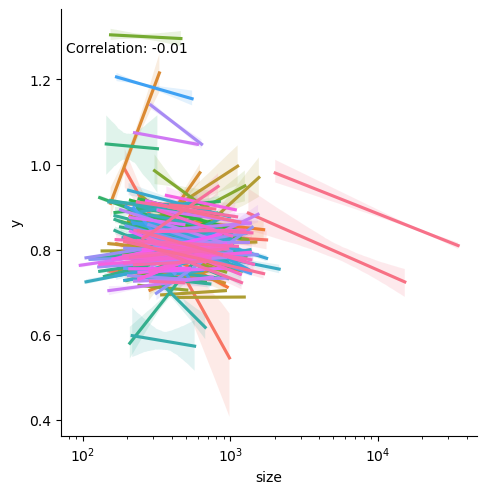

In [9]:
import seaborn as sns

df_projected_tracks.dropna(inplace=True)

corr = np.corrcoef(df_projected_tracks['size'], df_projected_tracks['y'])[0, 1]

sns.lmplot(
    x="size",
    y="y",
    data=df_projected_tracks,
    hue="track_id",
    scatter=False,
    legend=False,
    logx=True,
)

plt.text(0.01, 0.9, f"Correlation: {corr:.2f}", transform=plt.gca().transAxes)

plt.xscale('log')  # show log scale on x-axis
plt.show()

1. plot apparent size (area of bounding box) vs. estimated depth (world coordinate)
    - for each track
    - need to ensure there's a relationship otherwise no signal to estimate true size

3. Preprocessing --> finding number of frames on the mesh
    - What is the data we are conditioning on? The frames that we are picking w/ more certainty
    - Movement generator becomes an entirely 3D
    - Do we care about accurate 3d tracks? Or the size?

4. If 3d is noisy --> we want to separate GT from noise
    - Our model is "size changing bc of depth" --> check for tracks that we understand what is going on
    - Then size works as a regularizer for tracks

What do we do with the reprojected?

- We find ones w/ high confidence and use those as priors on the initial position

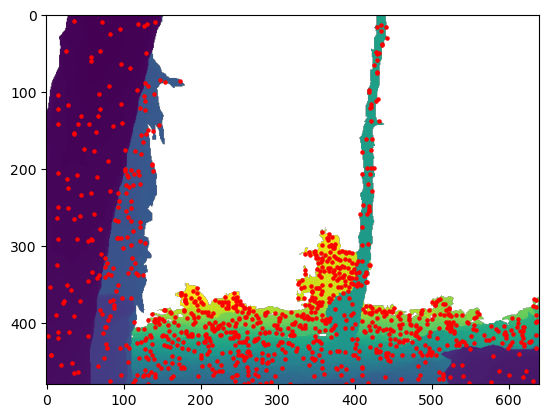

In [10]:
weights = camera.set_distribution(method='weighted')
points = camera.sample_pixels(n_points=1000)

plt.imshow(camera.depth)
plt.scatter(points[:, 0], points[:, 1], c="r", s=5)

In [344]:
import torch
import pyro
import pyro.distributions as dist

movement_generator = reprojection.MovementGenerator(
    mesh=mesh_environment, 
)

init_state = movement_generator.init_states(camera, n_agents=3)
positions, sizes = movement_generator.generate_trajectory(init_state, n_steps=100)


Generating trajectory: 100%|██████████| 100/100 [00:00<00:00, 940.01it/s]


Convert to dataframe of tracks

In [345]:
points = positions.permute(1, 0, 2).numpy()

all_tracks = []
track_colors = {}

# Generate random colors for each agent
for agent_id in range(points.shape[0]):
    # Generate random RGB values between 0 and 255
    random_color = np.random.randint(0, 255, size=3)
    track_colors[agent_id] = random_color.tolist()
    
    df_tracks = pd.DataFrame(columns= ["track_id", "x", "y", "z"])
    df_tracks["track_id"] = np.repeat(agent_id, points.shape[1])
    df_tracks["frame_id"] = np.arange(0, points.shape[1])

    df_tracks.loc[:, ["x", "y", "z"]] = points[agent_id]
    all_tracks.append(df_tracks)

df_tracks = pd.concat(all_tracks).reset_index(drop=True)
df_tracks = df_tracks.astype({'x': float, 'y': float, 'z': float})

df_tracks.head()

,track_id,x,y,z,frame_id
0,0,0.150038,1.280823,-0.178016,0
1,0,0.177161,1.296312,-0.175009,1
2,0,0.183862,1.297412,-0.175439,2
3,0,0.180255,1.305342,-0.165639,3
4,0,0.166660,1.301923,-0.200663,4


Plot the tracks

(-0.5, 2999.5, 2999.5, -0.5)

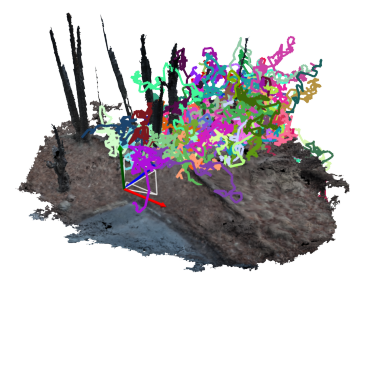

In [346]:
# Copy our camera parameters and format for pyvista
# TLB --> NEED TO FIX, IDK WHY IT INTERNALLY ALTERS PV_CAMERA
pv_camera = deepcopy(camera_params)
_ = viz.format_pyvista_camera_params(pv_camera)

# Create our camera pose
poses = [pv_camera["c2w"]]

# Format camera frustrum
camera_kwargs = viz.CAMERA_KWARGS.copy()
camera_kwargs.update(
    {
        "line_width": 10,
        "scale": 0.025,
        "opacity": 0.9,
        "color": [0.9, 0.9, 0.9],
        "show_axes": True,
    }
)

line_kwargs = {
    "line_width": 20,
    "opacity": 1.0,
}

# Make a plotter
plotter = viz.visualize_splat(
    mesh_fn.as_posix(),
    poses,
    mesh_kwargs=viz.MESH_KWARGS,
    viz_kwargs=viz.VIZ_KWARGS,
    camera_kwargs=camera_kwargs,
)

# Add the tracks to the plotter
plotter = viz.add_tracks_to_mesh(
    df_tracks,
    plotter,
    colors=track_colors,
    line_kwargs=line_kwargs,
    # plot_points=True,
)

mesh_image = plotter.screenshot(
    window_size=(3000, 3000),
    transparent_background=True,
    return_img=True,
)

# plotter.show(window_size=(800, 800))
plt.imshow(mesh_image)
plt.axis("off")

#### Movements model

In [98]:
def batch_agents(positions, sizes):
    """
    Create a batch of agents.
    """
    batch = []
    for i, (position, size) in enumerate(zip(positions, sizes)):
        trajectory = reprojection.StateTrajectory(position, size)
        agent = reprojection.Agent(id=f"agent_{i}", trajectory=trajectory)
        batch.append(agent)
    return batch

In [281]:
# Positions agent first
agent_positions = positions.permute(1, 0, 2)
agent_sizes = sizes.permute(1, 0, 2)

agents = batch_agents(agent_positions, agent_sizes)
centroid, area = camera.observe_batch(agents)

In [405]:
def movements_model(mesh, camera, n_agents=3, n_steps=100):
    """
    Model for movements of agents.
    """

    #########################################################
    ############## Sample spatial increment #################
    #########################################################

    movement_generator = reprojection.MovementGenerator(
        mesh=mesh, 
    )

    centroid_dist = dist.LogNormal(torch.log(torch.tensor(0.01)), 0.01)
    area_dist = dist.LogNormal(torch.log(torch.tensor(0.01)), 0.01)

    # Generate initial positions and sizes for all agents
    with pyro.plate("agents", n_agents, dim=-1):

        camera.set_distribution(n_agents=n_agents)

        # This already contains an agents plate internally --> should probably refactor
        init_state = movement_generator.init_states(camera, n_agents=n_agents)
        
        # Sample noise variances for observations
        centroid_noise = pyro.sample(
            name="centroid_noise", 
            fn=centroid_dist
        ).unsqueeze(-1)
        
        area_noise = pyro.sample(
            name="area_noise", 
            fn=area_dist
        ).unsqueeze(-1)

    print (n_agents)
    
    # Generate trajectories for all agents
    trajectories = movement_generator.generate_trajectory(init_state, n_steps=n_steps)

    # Create a batch of agents (positions and sizes)
    agents = batch_agents(trajectories[0], trajectories[1])

    # Observe the agents --> this gives us the "ground truth" observations
    observed_centroids, observed_areas = camera.observe_batch(agents)

    with pyro.plate("steps", n_steps, dim=-3):      # operates on steps dimension
        with pyro.plate("agents_steps", n_agents, dim=-2): # operates on agents dimension
            # to_event moves right-to-left establishing dependent dimnesions
            centroids = pyro.sample(
                "centroids",
                dist.Normal(observed_centroids, centroid_noise).to_event(0)
            )

            areas = pyro.sample(
                "areas",
                dist.LogNormal(torch.log(observed_areas), area_noise).to_event(0)
            )
    
    return (centroids, areas), trajectories


In [408]:
import torch
import pyro
from pyro import poutine
from pyro.infer import SVI, Trace_ELBO, Predictive, config_enumerate, TraceEnum_ELBO
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Tuple

def map_sizes(
    mesh,
    camera,
    observed_trajectory: Tuple[torch.Tensor, torch.Tensor],
    num_svi_steps: int = 1000,
    show_loss: bool = False,
    *args,
    **kwargs
) -> dict:
    """
    Fit a MAP estimate for the movements_model conditioned on observed trajectory.

    Args:
        observed_trajectory: Tuple of (centroids, areas)
            centroids: (n_steps, n_agents, 2)
            areas: (n_steps, n_agents, 1)
        num_svi_steps: Number of SVI steps for optimization
        show_loss: Whether to plot the loss curve
        *args, **kwargs: Additional arguments passed to movements_model

    Returns:
        dict: MAP estimates for the latent variables
    """

    # These are observed values (e.g., camera observations of agents + areas)
    observed_centroids, observed_areas = observed_trajectory

    def conditioned_model():
        # Condition the movements_model on observed data
        with pyro.condition(data={"centroids": observed_centroids, "areas": observed_areas}):
            return movements_model(mesh, camera, *args, **kwargs)

    # Correct
    guide = AutoDelta(
        poutine.block(conditioned_model, hide=["pixels"])
    )

    # Enumeration is only for the SVI model, not the guide
    enumerated_model = config_enumerate(conditioned_model, "parallel")

    svi = SVI(
        model=enumerated_model,
        guide=guide,
        optim=Adam({"lr": 0.01}),
        loss=Trace_ELBO(max_plate_nesting=3)
    )

    # Training loop
    losses = []
    with tqdm(total=num_svi_steps, desc="Training MAP") as pbar:
        for step in range(num_svi_steps):
            loss = svi.step()
            losses.append(loss)
            pbar.set_postfix({"loss": f"{loss:.2f}"})
            pbar.update(1)

    # Optionally plot the loss
    if show_loss:
        plt.figure(figsize=(10, 6))
        plt.semilogy(losses)
        plt.xlabel("Step")
        plt.ylabel("Loss")
        plt.title("Loss during MAP training")
        plt.show()

    # Return MAP estimates
    predictive = Predictive(conditioned_model, guide=guide, num_samples=1)
    return predictive()

In [401]:
# Generate synthetic observations
# 1. Centroids / Areas with noise (observations)
# 2. Trajectories used to generate those centroids / areas
synthetic_observations, synthetic_trajectories = movements_model(mesh_environment, camera, n_agents=5, n_steps=100)

Generating trajectory: 100%|██████████| 100/100 [00:00<00:00, 913.13it/s]


In [409]:
map_sizes(
    mesh=mesh_environment,
    camera=camera,
    observed_trajectory=synthetic_observations,
    show_loss=True,
    n_agents=5,
    n_steps=100
)

Training MAP:   0%|          | 0/1000 [00:00<?, ?it/s]

5


Training MAP:   0%|          | 0/1000 [00:01<?, ?it/s]


ValueError: Inside pyro.plate(agents, 5, dim=-1) invalid shape of pyro.param(AutoDelta.init_size, ..., event_dim=1): torch.Size([3, 1])
            Trace Shapes:    
             Param Sites:    
      AutoDelta.init_size 3 1
 AutoDelta.centroid_noise   3
     AutoDelta.area_noise   3
 AutoDelta.spatial_step_0 3 3
 AutoDelta.spatial_step_1 3 3
 AutoDelta.spatial_step_2 3 3
 AutoDelta.spatial_step_3 3 3
 AutoDelta.spatial_step_4 3 3
 AutoDelta.spatial_step_5 3 3
 AutoDelta.spatial_step_6 3 3
 AutoDelta.spatial_step_7 3 3
 AutoDelta.spatial_step_8 3 3
 AutoDelta.spatial_step_9 3 3
AutoDelta.spatial_step_10 3 3
AutoDelta.spatial_step_11 3 3
AutoDelta.spatial_step_12 3 3
AutoDelta.spatial_step_13 3 3
AutoDelta.spatial_step_14 3 3
AutoDelta.spatial_step_15 3 3
AutoDelta.spatial_step_16 3 3
AutoDelta.spatial_step_17 3 3
AutoDelta.spatial_step_18 3 3
AutoDelta.spatial_step_19 3 3
AutoDelta.spatial_step_20 3 3
AutoDelta.spatial_step_21 3 3
AutoDelta.spatial_step_22 3 3
AutoDelta.spatial_step_23 3 3
AutoDelta.spatial_step_24 3 3
AutoDelta.spatial_step_25 3 3
AutoDelta.spatial_step_26 3 3
AutoDelta.spatial_step_27 3 3
AutoDelta.spatial_step_28 3 3
AutoDelta.spatial_step_29 3 3
AutoDelta.spatial_step_30 3 3
AutoDelta.spatial_step_31 3 3
AutoDelta.spatial_step_32 3 3
AutoDelta.spatial_step_33 3 3
AutoDelta.spatial_step_34 3 3
AutoDelta.spatial_step_35 3 3
AutoDelta.spatial_step_36 3 3
AutoDelta.spatial_step_37 3 3
AutoDelta.spatial_step_38 3 3
AutoDelta.spatial_step_39 3 3
AutoDelta.spatial_step_40 3 3
AutoDelta.spatial_step_41 3 3
AutoDelta.spatial_step_42 3 3
AutoDelta.spatial_step_43 3 3
AutoDelta.spatial_step_44 3 3
AutoDelta.spatial_step_45 3 3
AutoDelta.spatial_step_46 3 3
AutoDelta.spatial_step_47 3 3
AutoDelta.spatial_step_48 3 3
AutoDelta.spatial_step_49 3 3
AutoDelta.spatial_step_50 3 3
AutoDelta.spatial_step_51 3 3
AutoDelta.spatial_step_52 3 3
AutoDelta.spatial_step_53 3 3
AutoDelta.spatial_step_54 3 3
AutoDelta.spatial_step_55 3 3
AutoDelta.spatial_step_56 3 3
AutoDelta.spatial_step_57 3 3
AutoDelta.spatial_step_58 3 3
AutoDelta.spatial_step_59 3 3
AutoDelta.spatial_step_60 3 3
AutoDelta.spatial_step_61 3 3
AutoDelta.spatial_step_62 3 3
AutoDelta.spatial_step_63 3 3
AutoDelta.spatial_step_64 3 3
AutoDelta.spatial_step_65 3 3
AutoDelta.spatial_step_66 3 3
AutoDelta.spatial_step_67 3 3
AutoDelta.spatial_step_68 3 3
AutoDelta.spatial_step_69 3 3
AutoDelta.spatial_step_70 3 3
AutoDelta.spatial_step_71 3 3
AutoDelta.spatial_step_72 3 3
AutoDelta.spatial_step_73 3 3
AutoDelta.spatial_step_74 3 3
AutoDelta.spatial_step_75 3 3
AutoDelta.spatial_step_76 3 3
AutoDelta.spatial_step_77 3 3
AutoDelta.spatial_step_78 3 3
AutoDelta.spatial_step_79 3 3
AutoDelta.spatial_step_80 3 3
AutoDelta.spatial_step_81 3 3
AutoDelta.spatial_step_82 3 3
AutoDelta.spatial_step_83 3 3
AutoDelta.spatial_step_84 3 3
AutoDelta.spatial_step_85 3 3
AutoDelta.spatial_step_86 3 3
AutoDelta.spatial_step_87 3 3
AutoDelta.spatial_step_88 3 3
AutoDelta.spatial_step_89 3 3
AutoDelta.spatial_step_90 3 3
AutoDelta.spatial_step_91 3 3
AutoDelta.spatial_step_92 3 3
AutoDelta.spatial_step_93 3 3
AutoDelta.spatial_step_94 3 3
AutoDelta.spatial_step_95 3 3
AutoDelta.spatial_step_96 3 3
AutoDelta.spatial_step_97 3 3
AutoDelta.spatial_step_98 3 3
AutoDelta.spatial_step_99 3 3
            Sample Sites:    
              agents dist   |
                    value 5 |